In [1]:
import numpy as np
import copy
import numpy.ma as ma
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
import time
from sklearn import cluster
import nimfa  # non-negative matrix factorization
from statistics import median, mean

#functions
def save_approx(name_of_the_list, approx, i):
    if i == 4:  # save only approx rank 4
        name_of_the_list.append(approx)

import sys
sys.path.append("..")
import utils as ut
import distance_correlation as dc
import STMF as stmf  # sparse tropical matrix factorization

/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


In [2]:
m = 291 # patients  
n = 100 # genes  
missing_value = 0  # 99 is better than 0, because 0 can be the real value in data; we set missing value to be
# 0 since NMF skips 0s!
epsilon = 0.0000001
temp = 11  # 11
repeat = 5  # 5
max_iter = 500
sparsity = 0.2  # 20%
init = 'nndsvd'  # random, random_c, random_vcol, nndsvd
init_stmf = 'random_vcol'
folder_name = "OV"

# importing data
original_data = np.genfromtxt('../multi_omic/OV/OV_gene_subset.txt', delimiter='\t').T
original_data = np.delete(original_data, 0, axis=0)
original_data = np.delete(original_data, 0, axis=1)

# feature agglomeration columns
agglo = cluster.FeatureAgglomeration(n_clusters=100)
agglo.fit(original_data)
original_data = agglo.transform(original_data)

# polo rows
original_data, _, _ = ut.polo_clustering(original_data)

original_data += epsilon  
ut.check_zeros(original_data)
data = copy.deepcopy(original_data)

data = ut.create_matrix_with_missing_values(data, sparsity, missing_value)  # create matrix with missing values
data_missing = copy.deepcopy(data)
data = ma.masked_equal(data, missing_value)  # create masked array
print(original_data.shape)

(291, 100)


In [3]:
# NMF
print("NMF")
errors_nmf, corr_nmf, rmse_nmf, time_nmf = np.array([]), np.array([]), np.array([]), np.array([])
approx_nmf = []
U_nmf, V_nmf = 0, 0
for i in range(1, temp):
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    model = nimfa.Nmf(data, rank=i, max_iter=max_iter, seed=init)
    start_time_nmf = time.time()
    nmf = model()
    t_nmf = round(time.time() - start_time_nmf, 3)
    approx = np.dot(nmf.basis(), nmf.coef(idx=None))
    if i == 4:  # rank 4, all approximations of rank 4 are the same since nndsvd is non-randomized
        U_nmf = nmf.basis()
        V_nmf = nmf.coef(idx=None)
    error_iter = np.append(error_iter, ut.rmse(original_data, data_missing, approx, missing_value))
    correlation, a, b = dc.dcor(original_data, approx)
    if i==4:
        print("rank " + str(i) + ": " + str(correlation))
    corr_iter = np.append(corr_iter, correlation)
    correlations.append(correlation)
    approximations.append(approx)
    rmse_iter = np.append(rmse_iter, ut.rmse_approx(original_data, data_missing, approx, missing_value))
    save_approx(approx_nmf, approximations[np.argmax(correlations)], i)
    errors_nmf, corr_nmf, rmse_nmf, time_nmf = np.append(errors_nmf, error_iter), np.append(corr_nmf, corr_iter), np.append(rmse_nmf, rmse_iter), np.append(time_nmf, t_nmf)

# STMF
print("STMF")
errors_trop, corr_trop, rmse_trop, time_trop = np.array([]), np.array([]), np.array([]), np.array([])
approx_trop = []
factor_U, factor_V = [], []
U_stmf, V_stmf = 0, 0
for i in range(1, temp):
    error_iter, corr_iter, rmse_iter, time_iter = np.array([]), np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    for j in range(0, repeat):
        model = stmf.STMF(rank=i, criterion='iterations', max_iter=max_iter, initialization=init_stmf)
        model.fit(data)
        if i == 4:
            factor_U.append(model.U)
            factor_V.append(model.V)
        approx = model.predict_all()
        error_iter = np.append(error_iter, ut.rmse(original_data, data_missing, approx, missing_value))
        correlation, a, b = dc.dcor(original_data, approx)
        corr_iter = np.append(corr_iter, correlation)
        time_iter = np.append(time_iter, model.time)
        correlations.append(correlation)
        approximations.append(approx)
        rmse_iter = np.append(rmse_iter, ut.rmse_approx(original_data, data_missing, approx, missing_value))
    save_approx(approx_trop, approximations[np.argmax(correlations)], i)
    if i==4:
        print("rank " + str(i) + ", max: " + str(max(correlations)))
        print("rank " + str(i) + ", min: " + str(min(correlations)))
        print("rank " + str(i) + ", median: " + str(median(correlations)))
    if i == 4:
        U_stmf, V_stmf = factor_U[np.argmax(correlations)], factor_V[np.argmax(correlations)]
    errors_trop, corr_trop, rmse_trop, time_trop =  np.append(errors_trop, error_iter), np.append(corr_trop, corr_iter), np.append(rmse_trop, rmse_iter), np.append(time_trop, time_iter)

NMF
rank 4: 0.34667783752516684
STMF
rank 4, max: 0.6013207225866506
rank 4, min: 0.4204022906720099
rank 4, median: 0.5694680963503457


In [4]:
k = 1
# rmse
np.savetxt("results/" + folder_name + "/stmf_rmse_" + str(k) + ".csv", rmse_trop, delimiter=",") 
np.savetxt("results/" + folder_name + "/nmf_rmse_" + str(k) + ".csv", rmse_nmf, delimiter=",") 
# prediction error
np.savetxt("results/" + folder_name + "/stmf_err_" + str(k) + ".csv", errors_trop, delimiter=",") 
np.savetxt("results/" + folder_name + "/nmf_err_" + str(k) + ".csv", errors_nmf, delimiter=",") 
# correlation
np.savetxt("results/" + folder_name + "/stmf_corr_" + str(k) + ".csv", corr_trop, delimiter=",") 
np.savetxt("results/" + folder_name + "/nmf_corr_" + str(k) + ".csv", corr_nmf, delimiter=",") 

In [5]:
time_nmf[3]

0.324

In [6]:
# average running time of rank 4
print(mean(time_trop[15:20]))

253.7644


### VISUALIZATIONS

Error + correlation

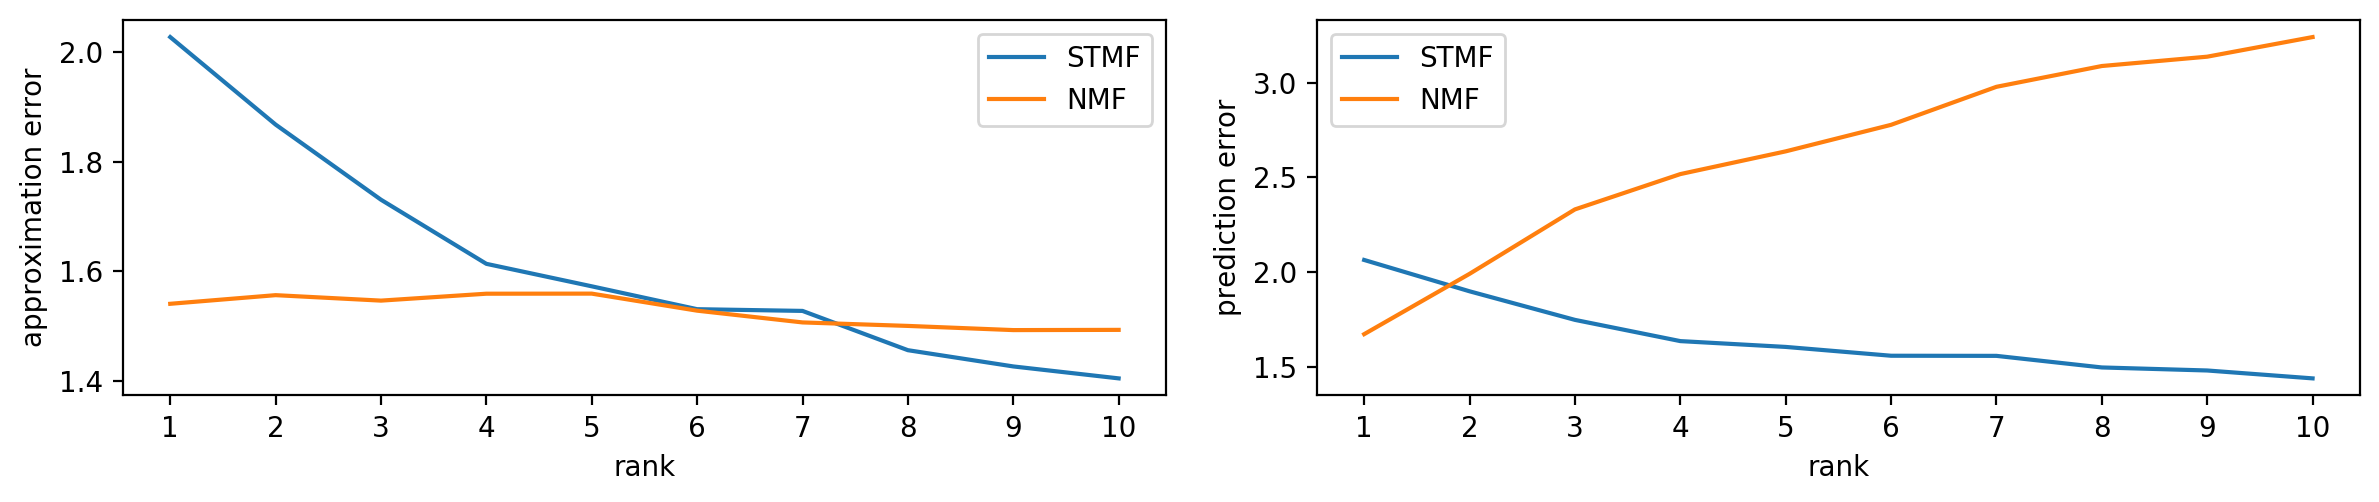

In [7]:
# approximation and prediction error (rmse)
ut.plot_approx_pred_ten(ut.create_dict_five(rmse_trop), ut.create_dict_nmf(rmse_nmf), ut.create_dict_five(errors_trop), ut.create_dict_nmf(errors_nmf), '', temp, "results/" + folder_name + "/approx_pred.png", "approximation error", "prediction error")

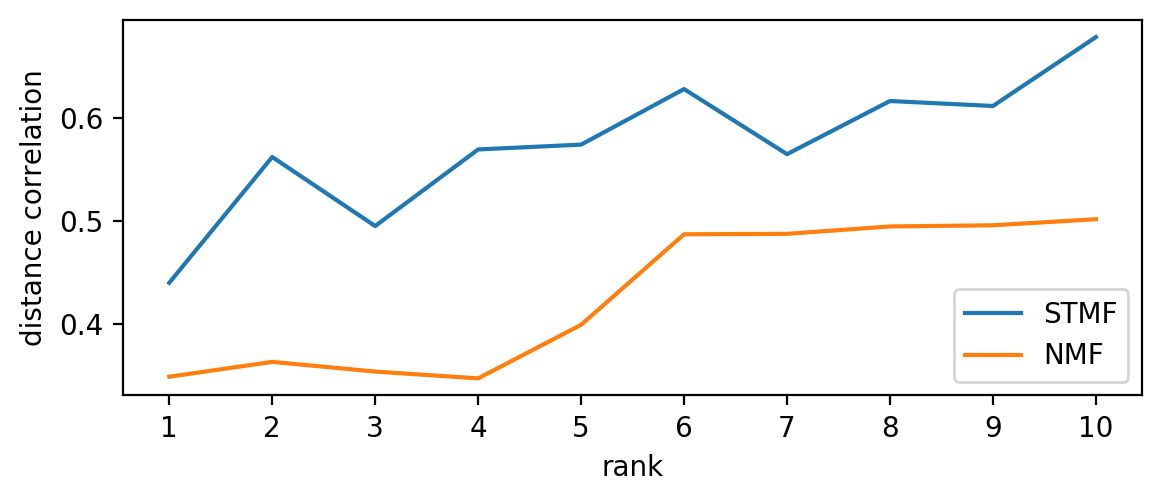

In [8]:
# correlation and silhouette score
ut.plot_corr_ten(ut.create_dict_five(corr_trop), ut.create_dict_nmf(corr_nmf), '', temp, "results/" + folder_name + "/corr.png", "distance correlation")

Approximation matrices

In [9]:
approx_stmf = approx_trop[0]
approx_nmf = approx_nmf[0]

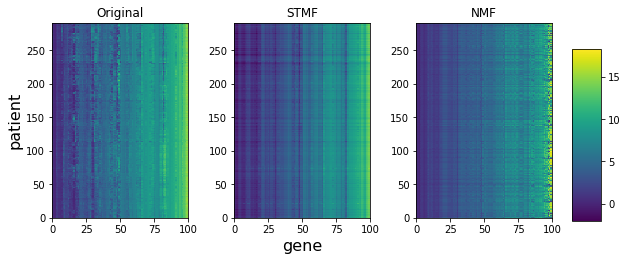

In [10]:
# Approximation of rank 4
ut.plot_original_trop_nmf_one_colorbar(original_data, approx_stmf, approx_nmf, "", "results/" + folder_name + "/original_stmf_nmf.png")

Factor matrices of rank 4

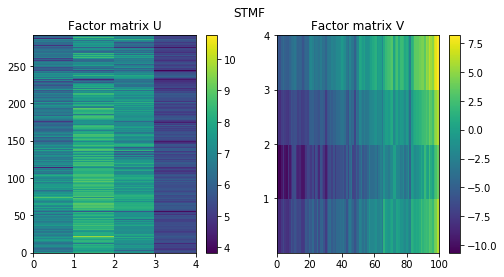

In [11]:
ut.plot_U_V_diff_scales_four(U_stmf, V_stmf, "STMF", "results/" + folder_name + "/factors_STMF.png")

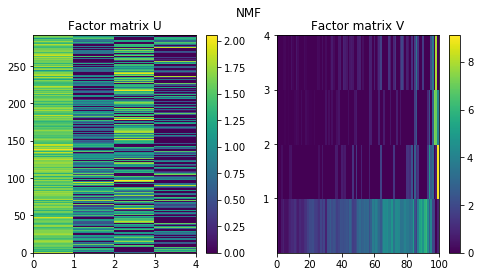

In [12]:
U_nmf, V_nmf = np.array(U_nmf), np.array(V_nmf)
ut.plot_U_V_diff_scales_four(U_nmf, V_nmf, "NMF", "results/" + folder_name + "/factors_NMF.png")

Latent matrices STMF

In [13]:
# latent matrix 1
x = U_stmf[:,0].reshape((m, 1))
y = V_stmf[0,:].reshape((1, n))
approx_rank_1 = np.add(x, y)

# latent matrix 2
x = U_stmf[:,1].reshape((m, 1))
y = V_stmf[1,:].reshape((1, n))
approx_rank_2 = np.add(x, y)

# latent matrix 3
x = U_stmf[:,2].reshape((m, 1))
y = V_stmf[2,:].reshape((1, n))
approx_rank_3 = np.add(x, y)

# latent matrix 4
x = U_stmf[:,3].reshape((m, 1))
y = V_stmf[3,:].reshape((1, n))
approx_rank_4 = np.add(x, y)

In [14]:
# binary matrices
approx_rank_1_binary = (approx_rank_1 == approx_stmf)
approx_rank_2_binary = (approx_rank_2 == approx_stmf)
approx_rank_3_binary = (approx_rank_3 == approx_stmf)
approx_rank_4_binary = (approx_rank_4 == approx_stmf)

# real values
approx_rank_1_real = np.ma.masked_array(approx_rank_1, mask=np.logical_not(approx_rank_1_binary))
approx_rank_2_real = np.ma.masked_array(approx_rank_2, mask=np.logical_not(approx_rank_2_binary))
approx_rank_3_real = np.ma.masked_array(approx_rank_3, mask=np.logical_not(approx_rank_3_binary))
approx_rank_4_real = np.ma.masked_array(approx_rank_4, mask=np.logical_not(approx_rank_4_binary))

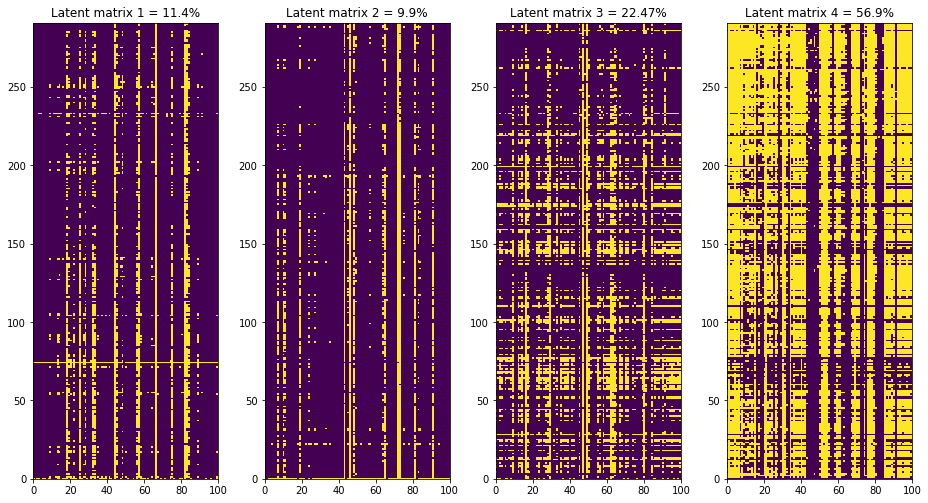

In [15]:
ut.plot_latent_binary_four(approx_rank_1_binary, approx_rank_2_binary, approx_rank_3_binary, approx_rank_4_binary, "results/" + folder_name + "/latent_stmf_binary.png")

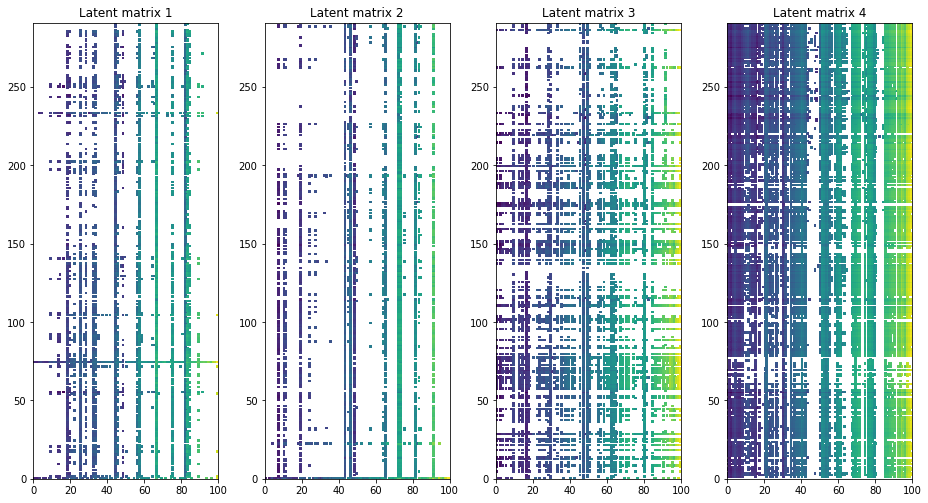

In [16]:
ut.plot_latent_real_four(approx_rank_1_real, approx_rank_2_real, approx_rank_3_real, approx_rank_4_real, "results/" + folder_name + "/latent_stmf_real.png")

Latent matrices NMF

In [17]:
# latent matrix 1
x = U_nmf[:,0].reshape((m, 1))
y = V_nmf[0,:].reshape((1, n))
approx_rank_1 = np.multiply(x, y)

# latent matrix 2
x = U_nmf[:,1].reshape((m, 1))
y = V_nmf[1,:].reshape((1, n))
approx_rank_2 = np.multiply(x, y)

# latent matrix 3
x = U_nmf[:,2].reshape((m, 1))
y = V_nmf[2,:].reshape((1, n))
approx_rank_3 = np.multiply(x, y)

# latent matrix 4
x = U_nmf[:,3].reshape((m, 1))
y = V_nmf[3,:].reshape((1, n))
approx_rank_4 = np.multiply(x, y)

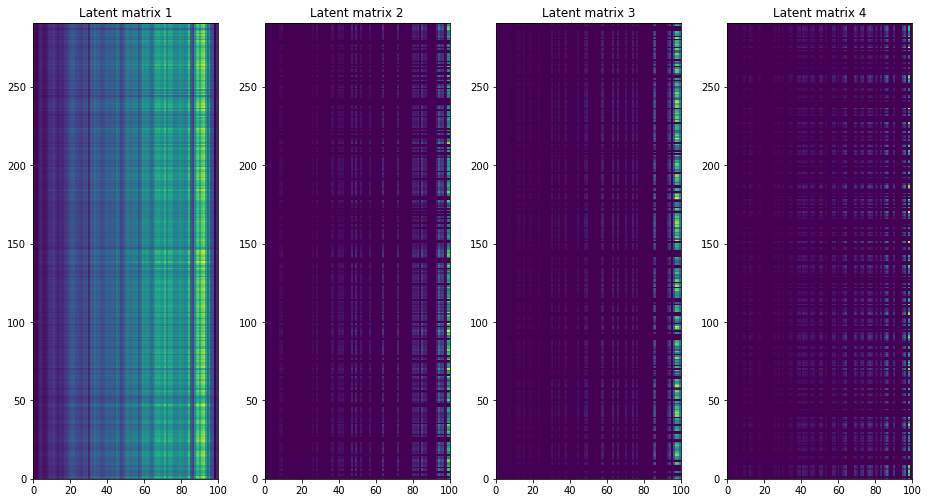

In [18]:
ut.plot_latent_real_four(approx_rank_1, approx_rank_2, approx_rank_3, approx_rank_4, "results/" + folder_name + "/latent_nmf_real.png")

Latent and approximation matrices of STMF and NMF

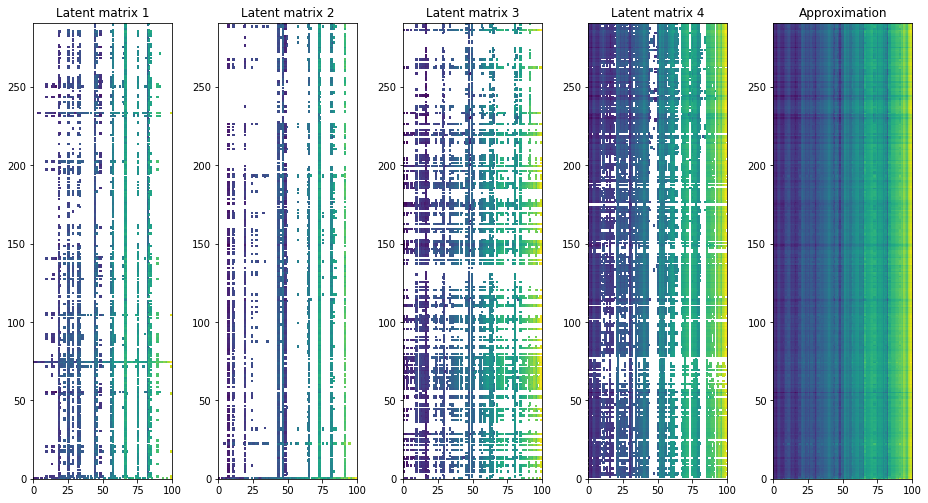

In [19]:
ut.plot_latent_real_approx_four(approx_rank_1_real, approx_rank_2_real, approx_rank_3_real, approx_rank_4_real, np.array(approx_stmf), "results/" + folder_name + "/latent_stmf_real_approx.png")

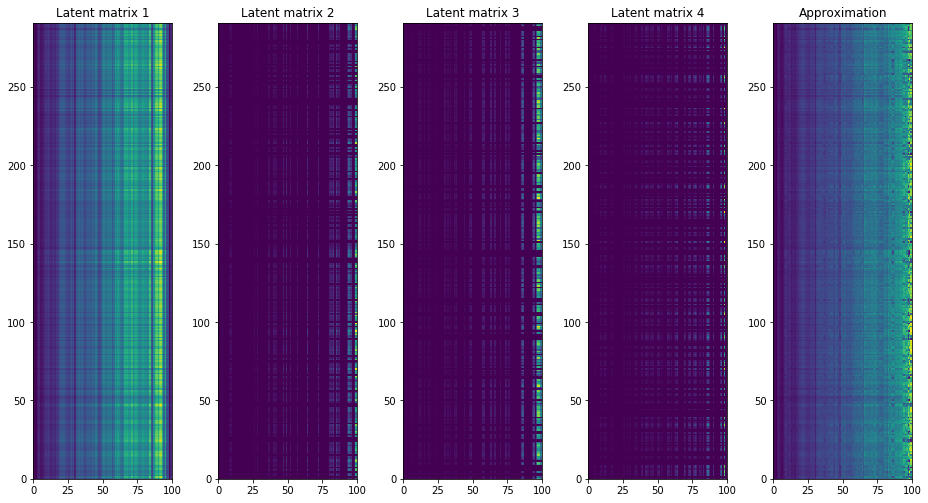

In [20]:
ut.plot_latent_real_approx_four(approx_rank_1, approx_rank_2, approx_rank_3, approx_rank_4, np.array(approx_nmf), "results/" + folder_name + "/latent_nmf_real_approx.png")

## Experiment 2

In [21]:
# stmf
distances, distance_correlation, pearson_correlation, spearman_correlation = ut.dist_corr(original_data, approx_stmf)
# nmf
distances_nmf, distance_correlation_nmf, pearson_correlation_nmf, spearman_correlation_nmf = ut.dist_corr(original_data, np.array(approx_nmf))

In [22]:
# stmf
np.savetxt("results/" + folder_name + "/distances.csv", distances, delimiter=',')
np.savetxt("results/" + folder_name + "/distance_correlation.csv", distance_correlation, delimiter=',')
np.savetxt("results/" + folder_name + "/pearson_correlation.csv", pearson_correlation, delimiter=',')
np.savetxt("results/" + folder_name + "/spearman_correlation.csv", spearman_correlation, delimiter=',')
# nmf
np.savetxt("results/" + folder_name + "/distances_nmf.csv", distances_nmf, delimiter=',')
np.savetxt("results/" + folder_name + "/distance_correlation_nmf.csv", distance_correlation_nmf, delimiter=',')
np.savetxt("results/" + folder_name + "/pearson_correlation_nmf.csv", pearson_correlation_nmf, delimiter=',')
np.savetxt("results/" + folder_name + "/spearman_correlation_nmf.csv", spearman_correlation_nmf, delimiter=',')

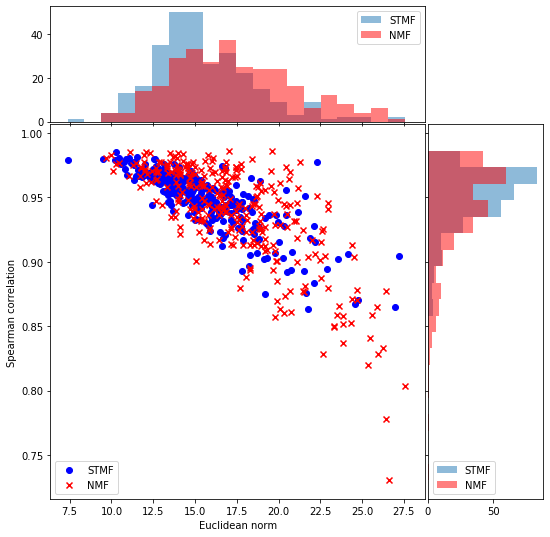

In [23]:
ut.scatter_hist(distances, spearman_correlation, distances_nmf, spearman_correlation_nmf, folder_name, "Euclidean norm", "Spearman correlation", "Spearman")

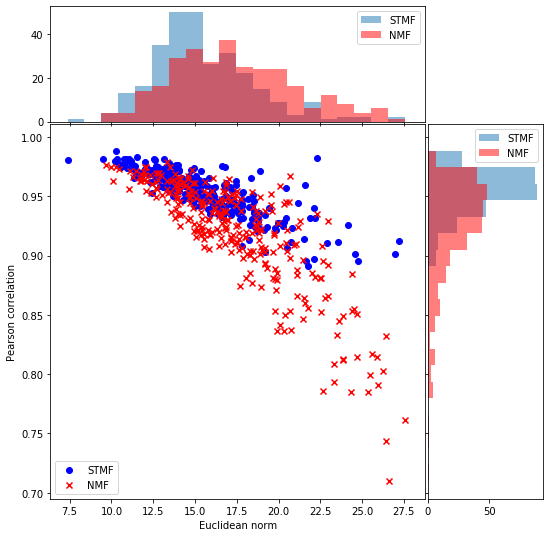

In [24]:
ut.scatter_hist(distances, pearson_correlation, distances_nmf, pearson_correlation_nmf, folder_name, "Euclidean norm", "Pearson correlation", "Pearson")

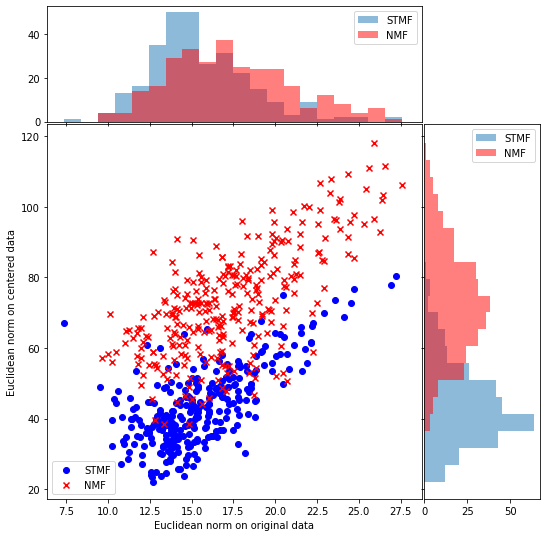

In [25]:
ut.scatter_hist(distances, distance_correlation, distances_nmf, distance_correlation_nmf, folder_name, "Euclidean norm on original data", "Euclidean norm on centered data", "Euclidean_norm")